In [3]:
import torch
from model import *
from unet import UNet
from ddpm import *
from PIL import Image
from torchvision.utils import make_grid
from pathlib import Path
import data
from itertools import islice
import matplotlib.pyplot as plt

In [4]:
device = 'cpu'

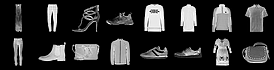

In [ ]:
train, test, info = data.load_dataset('CelebA')
# train, test, info = data.load_dataset()
imgs = torch.stack(list(map(lambda x: x[0], islice(train, 16))))
imgs = imgs.clamp(-1, 1).add(1).div(2).mul(255).byte()  # [-1., 1.] -> [0., 1.] -> [0, 255]
imgs = make_grid(imgs)
imgs = Image.fromarray(imgs.permute(1, 2, 0).cpu().numpy())
imgs

In [ ]:
# SNAPSHOT_PATH = sorted(list(Path('./snapshots').glob('*.pth')))[-1]

# model = SimpleUnetNoDownsample([16, 32, 32, 64])
# SNAPSHOT_PATH = './snapshots/SimpleUnetNoDownsample16-32-32-64-2024-11-29T08:45:43.644716.pth'

# model = SimpleUnetNoDownsample([16, 16, 32, 32, 32])
# SNAPSHOT_PATH = './snapshots/SimpleUnetNoDownsample16-16-32-32-32-2024-11-29T08:56:09.041281.pth'

# model = SimpleUnetClassCondNoDownsample([32, 32, 32, 64], num_classes=info.num_classes, spatial_encoding=True, device=device)
# SNAPSHOT_PATH = './models/SimpleUnetClassCondNoDownsample-spat-32-32-32-64-2024-11-29T09:59:57.172827.pth'

model = UNet(info.num_classes)
SNAPSHOT_PATH = './models/UNet-2024-12-08T17:46:48.272110.pth'

print(f"Loading {SNAPSHOT_PATH}")
snapshot = torch.load(SNAPSHOT_PATH)
sigma_data = snapshot['dataset_info']['sigma_data']

Loading ./models/UNet-2024-12-08T17:46:48.272110.pth


/tmp/ipykernel_583536/798827337.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot = torch.load(SNAPSHOT_PATH)


In [38]:
model.load_state_dict(snapshot['model_state_dict'])
model.eval()
()

()

In [42]:
sigmas = build_sigma_schedule(steps=100, rho=7)  # Sequence of decreasing sigmas

steps = []
with torch.no_grad():
    x = (torch.randn(8, 1, 32, 32) * sigmas[0])
    steps.append(x)
    cls = torch.tensor([5]).expand(x.shape[0]).int()
    for i, sigma in enumerate(sigmas):
        with torch.no_grad():
            cnoise = c_noise(sigma, sigma_data).expand(x.shape[0])
            cin = c_in(sigma, sigma_data)
            pred = model(cin*x, cnoise, cls)
            x_denoised = c_skip(sigma, sigma_data) * x + c_out(sigma, sigma_data) * pred
        sigma_next = sigmas[i + 1] if i < len(sigmas) - 1 else 0
        d = (x - x_denoised) / sigma
        x = x + d * (sigma_next - sigma)  # Perform one step of Euler's method
        steps.append(x)

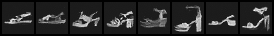

In [43]:
x = steps[-1]
x = x / x.max().abs()
x = x.clamp(-1, 1).add(1).div(2).mul(255).byte()  # [-1., 1.] -> [0., 1.] -> [0, 255]
x = make_grid(x)
x = Image.fromarray(x.permute(1, 2, 0).cpu().numpy())
x